In [1]:
# Imports
# Gymnasium imports
import gymnasium as gym 
from gymnasium import Env
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

# Import helpers
import numpy as np
import pandas as pd
import random
import os
import json
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from collections import deque

# Import stable baselines
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv, VecNormalize
from stable_baselines3.common.env_util import make_vec_env, SubprocVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_checker import check_env

from Environment.env_v9 import *
from Functions.visualization_functions import *

In [2]:
network_config_path = './Config/network_config_v1.json'
env_config_path = './Config/env_config_v1.json'

In [3]:
# Configuration of the network
with open(network_config_path) as file:
    network_config = file.read()

EP_LENGTH = 100

In [4]:
def load_config(config_file):

    with open(config_file, "r") as f:
        config = json.load(f)
    return config

def make_env(config_file="config.json"):

    config = load_config(config_file)

    env = SS_Mngmt_Env(
        network_config=network_config,
        EP_LENGTH=EP_LENGTH,
        render_mode="human",
        model_type="A2C",
        stockout_cost=config["stockout_cost"],
        order_cost=config["order_cost"],
        item_cost=config["item_cost"],
        stock_cost=config["stock_cost"],
        item_prize=config["item_prize"],
        progressive_stock_cost=config["progressive_stock_cost"],
        stock_out_max=config["stock_out_max"],
        order_quantities=config["order_quantities"],
        demand_mean=config["demand_mean"],
        demand_std=config["demand_std"],
        demand_noise=config["demand_noise"],
        demand_noise_std=config["demand_noise_std"],
        demand_prob=config["demand_prob"],
    )

    env = Monitor(env)

    return env

env = make_env(env_config_path)
check_env(env, warn=True)

/Users/jonasrenfer/miniconda3/envs/rl-scm/lib/python3.12/site-packages/stable_baselines3/common/env_checker.py:263: UserWarning: Your observation order_queues has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


In [5]:
log_path = os.path.join('Training', 'Logs', 'A2C')
model_path = os.path.join('Training', 'Models', 'A2C')

In [6]:
# Load the study from training
with open("./Training/A2C_optuna_study_2024-12-03_15_00.pkl", "rb") as f:
    study = pickle.load(f)

print("Best parameters from loaded study:", study.best_params)

Best parameters from loaded study: {'learning_rate': 0.001607278354059312, 'gamma': 0.9317992416208083, 'ent_coef': 0.00015835228118501682, 'vf_coef': 0.8804902995072191, 'n_steps': 7, 'max_grad_norm': 0.5744588537022318, 'gae_lambda': 0.8575127064782713, 'use_rms_prop': False}


/Users/jonasrenfer/miniconda3/envs/rl-scm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
vec_env = DummyVecEnv([lambda: make_env("./Config/env_config_v0.json")])
vec_env = VecNormalize(vec_env, norm_obs=True, norm_reward=True, clip_obs=10.0)

# num_envs = 4  # Adjust based on your system

# vec_env = SubprocVecEnv([lambda: make_env(env_config_path) for _ in range(num_envs)])
# vec_env = VecNormalize(vec_env, norm_obs=True, norm_reward=True, clip_obs=10.0)

best_params = study.best_params

# model = A2C("MultiInputPolicy",
#             vec_env,
#             learning_rate=best_params["learning_rate"],
#             gamma=best_params["gamma"],
#             ent_coef=best_params["ent_coef"],
#             vf_coef=best_params["vf_coef"],
#             n_steps=best_params["n_steps"],
#             max_grad_norm=best_params["max_grad_norm"],
#             gae_lambda=best_params["gae_lambda"],
#             use_rms_prop=best_params["use_rms_prop"],
#             verbose=0,
#             )

model = A2C("MultiInputPolicy",
            vec_env, 
            learning_rate=0.0005,
            gamma=0.99,
            n_steps=10,
            ent_coef=0.01,
            vf_coef=0.5,
            max_grad_norm=0.5,
            tensorboard_log=log_path,
            verbose=0)


In [8]:
model.learn(total_timesteps=500_000)

In [9]:
model.save(os.path.join(model_path, "A2C_SS_Mngmt_v0"))

In [10]:
evaluate_policy(model, vec_env, n_eval_episodes=20, render=False, return_episode_rewards=True)

([-55652.7,
  -51642.22,
  -50772.56,
  -48043.21,
  -50186.52,
  -51780.19,
  -53660.13,
  -55054.32,
  -52284.48,
  -56644.65,
  -50405.0,
  -53314.37,
  -53557.58,
  -51242.68,
  -52045.28,
  -49756.63,
  -55638.26,
  -49213.42,
  -54366.32,
  -52459.51],
 [4, 9, 9, 11, 9, 9, 6, 5, 7, 4, 11, 7, 7, 10, 7, 10, 6, 11, 8, 9])

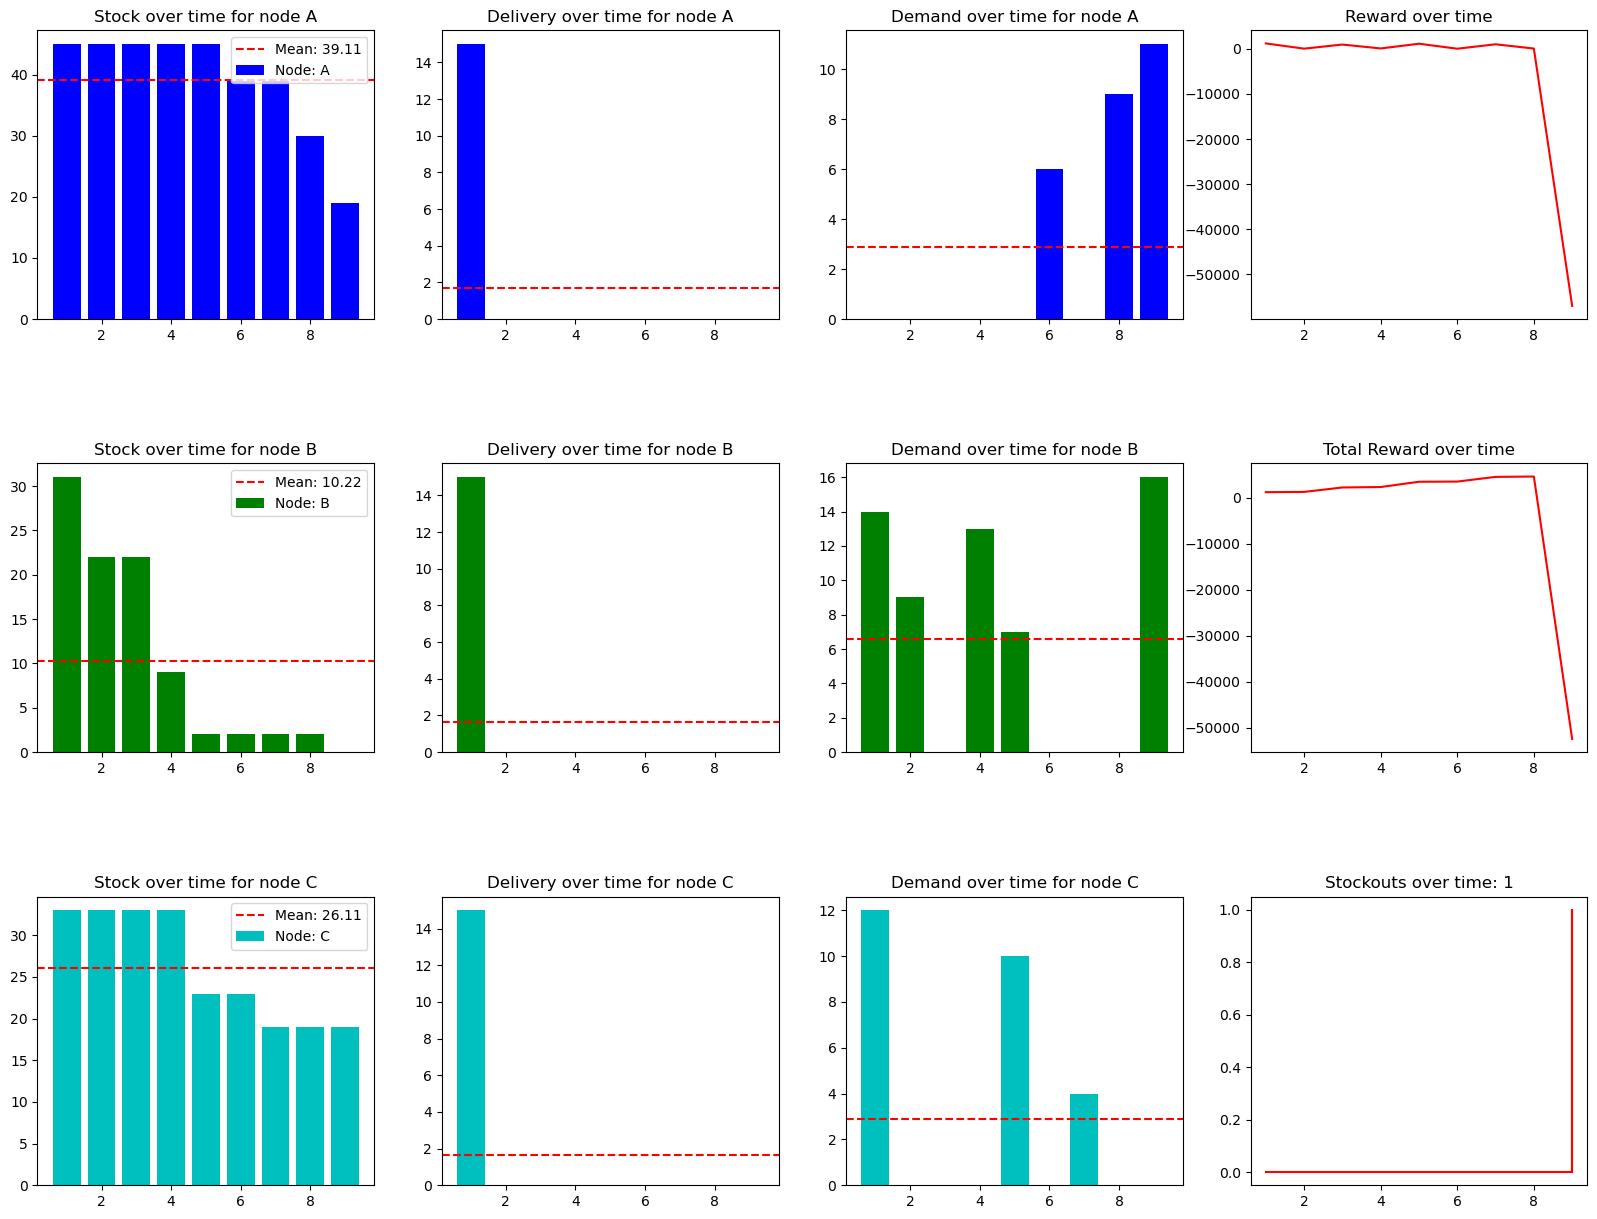

In [11]:
file = './Data/2024-12-03_environment_data_A2C.csv'
df = pd.read_csv(file)

plot_data(df)

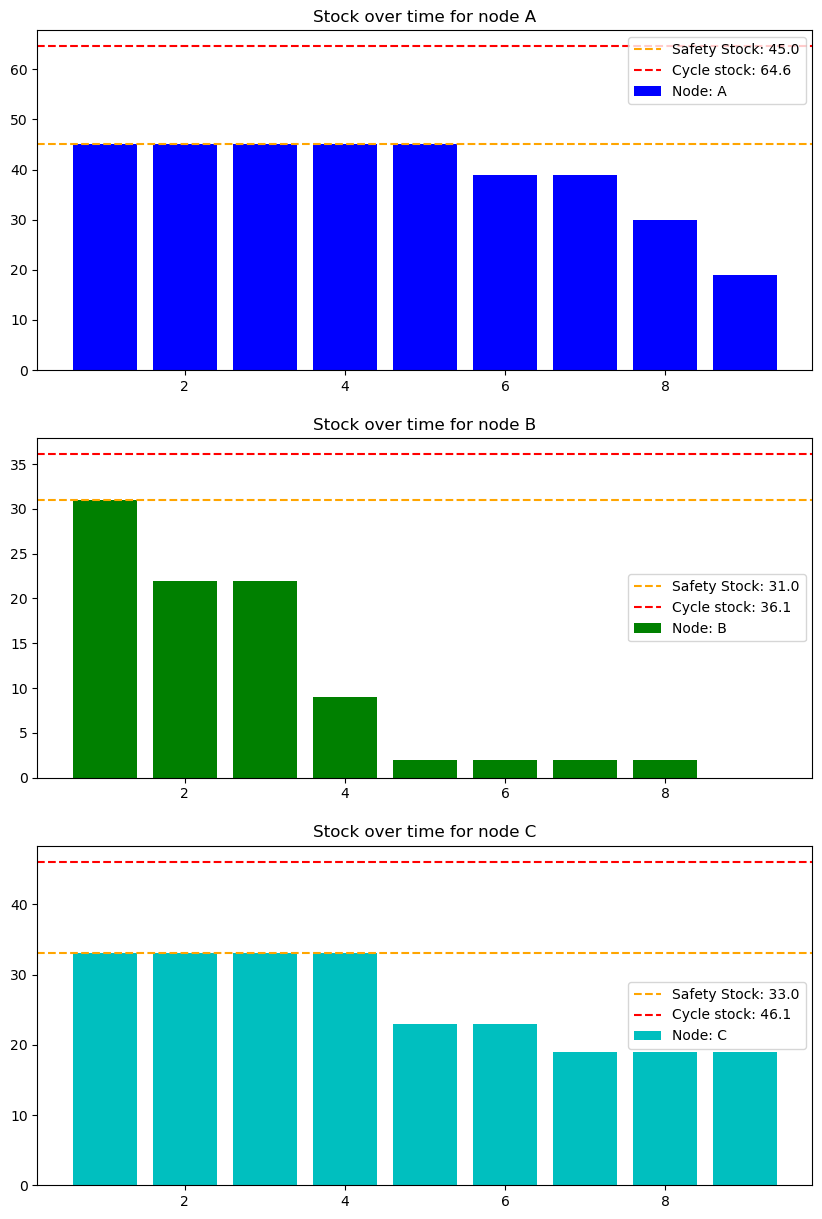

In [12]:
plot_safety_stock(df)